In [342]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
from math import *

from scipy import integrate
from scipy import interpolate

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

from poliastro.bodies import Sun,Venus, Earth, Jupiter, Saturn
from poliastro.threebody import flybys
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D
from poliastro.util import norm
import poliastro.twobody.propagation as Propagation

from scipy import optimize as opt
 
solar_system_ephemeris.set("jpl")



<ScienceState solar_system_ephemeris: 'jpl'>

In [343]:
r_saturn=norm(Orbit.from_body_ephem(Saturn).r)
v_saturn=norm(Orbit.from_body_ephem(Saturn).v)
r_earth=norm(Orbit.from_body_ephem(Earth).r)
v_earth=norm(Orbit.from_body_ephem(Earth).v)

#determine the optimal earth-saturn transfer details
deltav_saturn_insertion_max = 500*u.m/u.s;
ve_plus_min = (deltav_saturn_insertion_max**2 - 2*deltav_saturn_insertion_max*v_saturn + Sun.k*(2/r_earth - 1/r_saturn))**0.5

print('ve_plus_min: ', ve_plus_min.to(u.km/u.s))
print('v_earth:     ', v_earth.to(u.km/u.s))

vinf = ve_plus_min.to(u.km/u.s)-v_earth.to(u.km/u.s)
print('vinf:        ', vinf.to(u.km/u.s))

q = Earth.R + 1500*u.km
print('q:           ', q)

max_dv_earth_flyby = 2*vinf/(1 + (vinf**2 * q)/Earth.k)
print('max dv Earth:',max_dv_earth_flyby)

max_psi = 2*np.arcsin((1+vinf**2*q/Earth.k)**-1)
print('psi_max:     ',max_psi,'=',max_psi.to(u.deg))

def beta_eqn(beta):
    beta = beta
    return (v_earth/(vinf*sin(beta))) + 1/tan(beta) - 1/tan(max_psi.value)

try:
    beta_max = opt.broyden1(beta_eqn, pi/2, f_tol=1e-14)
except:
    beta_max = pi/2;
print('beta_max:    ',beta_max)

ve_minus_radial_max = vinf*sin(beta_max)
print('ve_minus_radial_max: ', ve_minus_radial_max.to(u.km/u.s))

ve_minus_tangential_min = v_earth - vinf
print('ve_minus_tang_min:   ', ve_minus_tangential_min.to(u.km/u.s))

ve_plus_min:  40.86661684497215 km / s
v_earth:      29.56096505604003 km / s
vinf:         11.30565178893212 km / s
q:            7878136.6 m
max dv Earth: 6.412273843708598 km / s
psi_max:      0.5750654222802504 rad = 32.948821640566806 deg
beta_max:     1.5707963267948966
ve_minus_radial_max:  11.30565178893212 km / s
ve_minus_tang_min:    18.25531326710791 km / s


In [344]:
# -*- coding: utf-8 -*-
# Adapted from 2017 Interstellar Technologies Inc. All Rights Reserved.



class Orbiter:
    def __init__(self):
        
        #note, if d_ is used, it refers to dimensional quantity in SI units. 
        
        AU = 1.5*10**11;
        mu_sun = (6.67*10**-11)*(2*10**30) #SI units
        year = 3.154*10**7 #seconds
        self.year = year;
        
        #set up non-d params
        
        self.lref = 1*AU; #1 AU
        self.vref = sqrt(mu_sun/self.lref) #v of earths orbit
        self.tref = self.lref/self.vref
        self.aref = (self.vref)**2/self.lref
        self.wref = 1/self.tref;
        
        self.d_mdry = 2800; #kg
        
        #assign operating limits
        self.d_a_max = 2*0.5/self.d_mdry; #assuming 0.5N for vehicle mass of 5000 kg
        
        self.d_tf_max =5*year;
        
        
        #assign initial conditions
        self.d_r0 = 1*AU;
        self.d_vr0 = 0;
        self.d_vt0 = sqrt(mu_sun/(1*AU));
        self.d_w0 =self.d_vt0/self.d_r0; #earths orbital speed
        
        self.d_v_c3 = ((30)**0.5)*1000; #m/s
        
        
        self.d_rf = 1*AU;
        self.d_vrf = 0;
        self.d_final_apogee = 3*AU;
        self.d_final_semimajor = (self.d_rf+self.d_final_apogee)/2;        
        self.d_vtf = sqrt(mu_sun*(2/self.d_rf - 1/self.d_final_semimajor)); #vis viva equation at venus apogee.
        self.d_wf = self.d_vtf/self.d_rf;
        
        
        #non-dimensionalise
        self.u_max  = self.d_a_max/self.aref;
        self.r0     = self.d_r0 /self.lref;
        self.vr0    = self.d_vr0/self.vref;
        self.vt0    = self.d_vt0/self.vref;
        self.rf     = self.d_rf /self.lref;
        self.vrf    = self.d_vrf/self.vref;
        self.vtf    = self.d_vtf/self.vref;
        self.tf_max = self.d_tf_max/self.tref;
        self.v_c3   = self.d_v_c3/self.vref;
        self.w0     = self.d_w0/self.wref;
        
        self.theta_satellite = 0;
        self.theta_earth = 0;


def dynamics(prob, obj, section):
    r   = prob.states(0, section)
    vr  = prob.states(1, section)
    vt  = prob.states(2, section)
    ur = prob.controls(0, section)
    ut = prob.controls(1, section)

    dx = Dynamics(prob, section)
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2 + ur
    dx[2] = - vr * vt / r + ut
    return dx()


def equality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur = prob.controls_all_section(0)
    ut = prob.controls_all_section(1)
    tf  = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(r[0], obj.r0)
    result.equal(r[-1], obj.rf)
    
    result.equal(vr[0], obj.vr0)
    #result.equal(vt[-1], ((v_earth-(vinf**2-(vr[-1]*obj.vref*u.m/u.s)**2)**0.5).to(u.m/u.s).value)/obj.vref) #assuming vt is smaller than ve
    result.equal(vt[-1], v_earth+sqrt(vinf**2-vr[-1]**2)) #assuming vt is larger than ve
    
    #phasing condition
    time = prob.time_all_section    
    theta_satellite = (integrate.trapz(vt / r, time))/(2*pi)
    theta_earth = obj.w0*tf/(2*pi);
    result.equal(theta_satellite%1,theta_earth%1)
    
    obj.theta_satellite = theta_satellite;
    obj.theta_earth     = theta_earth;

    return result()


def inequality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    ur = prob.controls_all_section(0)
    ut = prob.controls_all_section(1)
    tf  = prob.time_final(-1)

    result = Condition()

    # ranges
    result.lower_bound(r, 0.5*min(obj.r0,obj.rf))
    result.upper_bound(r, 4*max(obj.r0,obj.rf))
    
    result.lower_bound(ur, -obj.u_max)
    result.lower_bound(ut, -obj.u_max)
    result.upper_bound(ur, obj.u_max)
    result.upper_bound(ut, obj.u_max)
    result.upper_bound(np.square(ur) + np.square(ut), obj.u_max**2)
    
    
    #starting    
    result.lower_bound(tf, 0.0)
    result.upper_bound(vt[0],obj.vt0+obj.v_c3)
    
    #finishing
    result.upper_bound(tf, obj.tf_max)
    result.lower_bound(vr[-1],-ve_minus_radial_max.to(u.m/u.s).value/obj.lref)
    result.upper_bound(vr[-1],+ve_minus_radial_max.to(u.m/u.s).value/obj.lref)



    return result()


def cost(prob, obj):
    return 0.0


def running_cost(prob, obj):
    ur = prob.controls_all_section(0)
    ut = prob.controls_all_section(1)
    
    netaccel = np.sqrt(np.square(ur) + np.square(ut));

    return netaccel



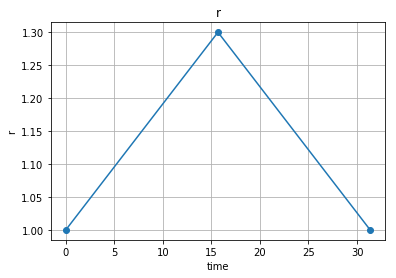

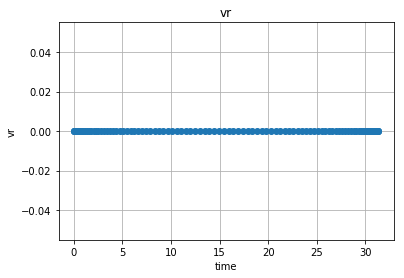

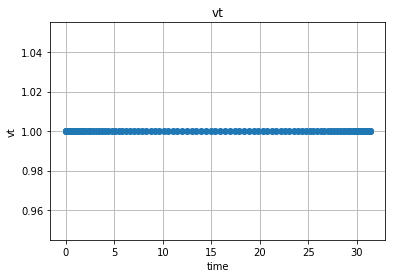

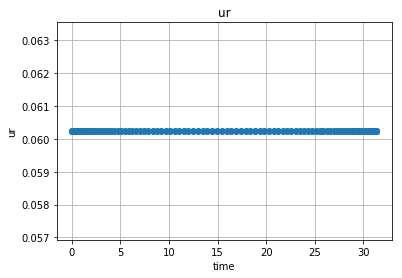

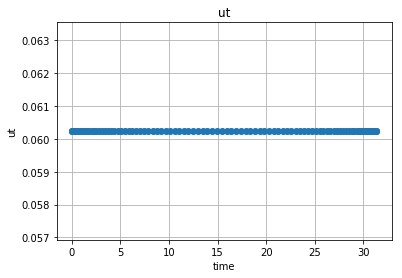

In [345]:

# ========================
plt.close("all")
plt.ion()
# Program Starting Point

obj = Orbiter()


time_init = [0.0, obj.tf_max]
n = [100]
num_states = [3]
num_controls = [2]
max_iteration = 6

flag_savefig = False

savefig_dir = "10_Low_Thrust_Orbit_Transfer/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)


# ========================
# Initial parameter guess
t_guess  =                       [0, obj.tf_max/2, obj.tf_max]
r_guess  = [r*obj.r0    for r in [1, 1.3, 1.0]]

Guess.plot(t_guess,r_guess, "r", "time", "r")
if(flag_savefig):plt.savefig(savefig_dir + "guess_r" + savefig_add + ".png")

vr_init = Guess.linear(prob.time_all_section, 0, 0)
Guess.plot(prob.time_all_section, vr_init, "vr", "time", "vr")
if(flag_savefig):plt.savefig(savefig_dir + "guess_vr" + savefig_add + ".png")

vt_init = Guess.linear(prob.time_all_section, obj.vt0, obj.vt0)
Guess.plot(prob.time_all_section, vt_init, "vt", "time", "vt")
if(flag_savefig):plt.savefig(savefig_dir + "guess_vt" + savefig_add + ".png")

ur_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)

Guess.plot(prob.time_all_section, ur_init, "ur", "time", "ur")
if(flag_savefig):plt.savefig(savefig_dir + "guess_ur1" + savefig_add + ".png")

ut_init = Guess.linear(prob.time_all_section, obj.u_max, obj.u_max)
Guess.plot(prob.time_all_section, ut_init, "ut", "time", "ut")
if(flag_savefig):plt.savefig(savefig_dir + "guess_ut1" + savefig_add + ".png")



In [346]:
t_guess_f = prob.time_all_section;

r_interp = interpolate.interp1d(t_guess,r_guess)

prob.set_states_all_section(0,r_interp(t_guess_f))
prob.set_states_all_section(1, vr_init)
prob.set_states_all_section(2, vt_init)
prob.set_controls_all_section(0, ur_init)
prob.set_controls_all_section(1, ut_init)


# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality


def display_func():
    tf = prob.time_final(-1)
    rmax = max(prob.states_all_section(0))
    print("tf: {0:.5f} years".format(tf*obj.tref/obj.year))
    print("rmax: {0:.5f} AU".format(rmax))
    print("theta_sat: {0:.5f}".format(obj.theta_satellite))
    print("theta_E  : {0:.5f}".format(obj.theta_earth))





In [347]:
prob.solve(obj, display_func, ftol=1e-2)

---- iteration : 1 ----


TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [ ]:

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
r = prob.states_all_section(0)
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
ur = prob.controls_all_section(0)
ut = prob.controls_all_section(1)

time = prob.time_update()

year = obj.year #seconds

accel_mag=np.sqrt(np.square(ur)+np.square(ut))



# ------------------------
# Visualizetion
plt.figure()
plt.plot(time*obj.tref/year, r, marker=".", label="r")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("r [AU]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "r" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, vr, marker=".", label="vr")
plt.plot(time*obj.tref/year, vt, marker=".", label="vt")
for line in prob.time_knots():
    plt.axvline(line*obj.tref/year, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("velocity [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "velocity" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, (ur)*obj.aref, marker=".", label="ar")
plt.plot(time*obj.tref/year, (ut)*obj.aref, marker=".", label="at")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("accel [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, accel_mag*obj.aref, marker=".", label="a_mag")
plt.plot([0,time[-1]*obj.tref/year],[obj.u_max*obj.aref,obj.u_max*obj.aref],'k:')
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_mag [m/s2]")
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ur*obj.aref, marker=".", label="ar_out")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_radial [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, ut*obj.aref, marker=".", label="at_pro")
plt.grid()
plt.xlabel("time [yr]")
plt.ylabel("accel_tangential [m/s2]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

if(flag_savefig): plt.savefig(savefig_dir + "thrust" + ".png")


from scipy import integrate
from scipy import interpolate

theta = integrate.cumtrapz(vt / r, time, initial=0)
theta_f = interpolate.interp1d(time, theta)
r_f = interpolate.interp1d(time, r)
time_fine = np.linspace(time[0], time[-1], 1000)
r_fine = r_f(time_fine)
theta_fine = theta_f(time_fine)

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r_fine*np.cos(theta_fine), r_fine*np.sin(theta_fine))
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()


#plot the burn direction vector

helioxaccel = (ur)*np.cos(theta) - (ut)*np.sin(theta)
helioyaccel = (ur)*np.sin(theta) + (ut)*np.cos(theta)

fig = plt.figure()
plt.plot(time,helioxaccel,label='helio x')
plt.plot(time,helioyaccel, label='helio y')

plt.show()

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.quiver(r*np.cos(theta), r*np.sin(theta), helioxaccel,helioyaccel)
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlim((-5*max(obj.r0,obj.rf),5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()

In [ ]:
plt.figure()
plt.plot(time_fine*obj.tref/year,360*((theta_fine/(2*pi))%1))
plt.plot(time_fine*obj.tref/year,360*((obj.w0*time_fine/(2*pi))%1))
plt.grid()

In [ ]:
#determine how long the transfer will take
final_time = prob.time_final_all_section()[0]
d_final_time = final_time*obj.tref
year = obj.year #seconds

print("Transfer time: ",d_final_time/year, "years")


if vt[0]-obj.vt0>0:
    direction='pro'
else:
    direction  = 'retro'
    
    
print("Required C3:   ", ((vt[0]-obj.vt0)*obj.vref/1000)**2, "km2/s2, ", direction)
#determine delta v and mass fraction
delv=np.trapz(y=accel_mag,x=time)
d_delv = delv*obj.vref
print("Required Delta-v: ", d_delv, "m/s")
mpm0=1-exp(-d_delv/(2020*9.81))
print("Propellant mass fraction: ", mpm0)

#final phase angle:
print("Arriving phase: ", theta_fine[-1], "rad")
print("Arriving phase: ", 360*((theta_fine[-1]/(2*pi))%1), 'deg')
print("Earth phase:    ", 360*(((obj.w0*final_time)/(2*pi))%1), 'deg')

In [ ]:
(theta_fine[-1]/(2*pi))

In [ ]:
((obj.w0*final_time)/(2*pi))

In [ ]:
0.1**2*30

In [ ]:
#integrate the dynamics from the end point

#define the passive dynamics
from scipy.integrate import odeint
def passiveDynamics(x,t):
    r = x[0]
    vr = x[1]
    vt = x[2]
    
    dx = [0,0,0]
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2
    dx[2] = - vr * vt / r
    
    return dx

#integrate using odeint
t_passive = np.linspace(final_time,final_time+2*year/obj.tref,10000)
x_passive = odeint(passiveDynamics,[r[-1],vr[-1],vt[-1]],t_passive)

#extract the radial position
r_passive = x_passive[:,0]


#plot the final solution
plt.figure()
plt.plot(time*obj.tref/year, r,'b')
plt.plot(t_passive*obj.tref/year, r_passive,'r')
plt.plot([0,final_time*obj.tref/year + 2],[obj.r0,obj.r0],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.rf,obj.rf],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.d_final_apogee/obj.lref,obj.d_final_apogee/obj.lref],'k:')
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("radius [AU]")

plt.show()

